In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import copy
import scipy
import random
from sklearn.metrics import confusion_matrix
import math

## Importing Dataset

In [77]:
df = pd.read_csv('Bank_Customer_Churn_Prediction.csv')

## Handling Imbalance Data
As we know this dataset is imbalance. However, in the following line codes I will try to balance it with a simple method that is going to devide the dataset into 50% in both classes. Furthermore, I will try to implement more balancing thechniques such as Oversampling and undersampling.

In [78]:
#the following script allows us to split our data to 50% has 1 as churn value
#and other 50% has 0 as churn value
#so we can at least garuantee to have eqaule classes in the target variable

#lets store the index of rows that has 0 in the churn in a list

L = list(df[df['churn']==0].index)
rand_idx = random.sample(L,5926)

In [79]:
#lets drop those random indexes
df = df.drop(rand_idx)
df['churn'].value_counts()

1    2037
0    2037
Name: churn, dtype: int64

## Handling Categorical Data


### Gender & Country

In [80]:
df = pd.get_dummies(df, columns = ['country', 'gender'])

## Standardization

In [81]:
df.columns

Index(['customer_id', 'credit_score', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary',
       'churn', 'country_France', 'country_Germany', 'country_Spain',
       'gender_Female', 'gender_Male'],
      dtype='object')

In [82]:
from sklearn.preprocessing import MinMaxScaler
vars_co = ['credit_score','age', 'tenure', 'balance','estimated_salary']
scaler = MinMaxScaler()
df[vars_co] = scaler.fit_transform(df[vars_co])

## Bank Churn using Multiple Hidden Layers and Improving the Performance of the Model

<a name='6'></a>
## He Initialization

Finally, try "He Initialization"; this is named for the first author of He et al., 2015. (If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])` where He initialization would use `sqrt(2./layers_dims[l-1])`.)

<a name='ex-3'></a>
### Initialize_parameters_he

Implement the following function to initialize your parameters with He initialization. This function is similar to the previous `initialize_parameters_random(...)`. The only difference is that instead of multiplying `np.random.randn(..,..)` by 10, you will multiply it by $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation. 

In [83]:
#FUNCTION: initialize_parameters_he

def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        #(≈ 2 lines of code)
        # parameters['W' + str(l)] = 
        # parameters['b' + str(l)] =
        # YOUR CODE STARTS HERE
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2./layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros([layers_dims[l],1])
        # YOUR CODE ENDS HERE
        
    return parameters

<a name='4'></a>
## - Forward Propagation Module

<a name='4-1'></a>
### - Linear Forward 

Now that I have initialized the parameters, I can do the forward propagation module. Start by implementing some basic functions that you can use again later when implementing the model. Now, you'll complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

<a name='ex-3'></a>
### - linear_forward 

Build the linear part of forward propagation.

**Reminder**:
The mathematical representation of this unit is $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$. You may also find `np.dot()` useful. If your dimensions don't match, printing `W.shape` may help.

In [84]:
#FUNCTION: linear_forward

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
  
    Z = np.dot(W,A) + b
    cache = (A, W, b)
    
    return Z, cache

<a name='4-2'></a>
### - Linear-Activation Forward

In this part of the project, I will use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. You've been provided with the `sigmoid` function which returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. You've been provided with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what you'll feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

For added convenience, you're going to group two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, you'll implement a function that does the LINEAR forward step, followed by an ACTIVATION forward step.

<a name='ex-4'></a>
### - linear_activation_forward

Implement the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). Use `linear_forward()` and the correct activation function.

In [85]:
#Function: Relu
def relu(Z):
    A = np.maximum(0, Z)
    return A, Z

In [86]:
#Function: Sigmoid
def sigmoid_l(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

In [87]:
#FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid_l(Z)
        
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

<a name='4-3'></a>
### - L-Layer Model 

For even *more* convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="./model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

<a name='ex-5'></a>
### -  L_model_forward

Implement the forward propagation of the above model.

**Instructions**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 


In [88]:
#FUNCTION: L_model_forward

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)],'relu')
        caches.append(cache)
        
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)],'sigmoid')
    caches.append(cache)
    
          
    return AL, caches

<a name='5'></a>
## - Cost Function

Now I can implement forward and backward propagation! I need to compute the cost, in order to check whether the model is actually learning.

<a name='ex-6'></a>
### - compute_cost
Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [108]:
#FUNCTION: compute_cost

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    logprobs = np.multiply(np.log(AL),Y) + np.multiply((1-Y),np.log(1-AL))
    cost = - np.sum(logprobs) / m
    
    
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    
    return cost

In [90]:
#FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    AL -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    L2_regularization_cost = 0
    m = Y.shape[1]
    L = len(parameters) // 2
    cross_entropy_cost = compute_cost(AL, Y) # This gives you the cross-entropy part of the cost
    
    #(≈ 1 lines of code)
    # L2_regularization_cost = 
    # YOUR CODE STARTS HERE
    for l in range(1, L + 1):
        L2_regularization_cost += (1/m)*(lambd/2)*(np.sum(np.square( parameters['W'+str(l)])))
    
    # YOUR CODE ENDS HERE
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

<a name='6'></a>
## - Backward Propagation Module

Just as I did for the forward propagation, I will implement helper functions for backpropagation. Remember that backpropagation is used to calculate the gradient of the loss function with respect to the parameters. 

**Reminder**: 
<img src="./backprop_kiank.png" style="width:650px;height:250px;">
<caption><center><font color='purple'><b>Figure 3</b>: Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID <br> <i>The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.</font></center></caption>


<!-- 
For those of you who are experts in calculus (which you don't need to be to do this assignment!), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

Now, similarly to forward propagation, I am going to build the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

<a name='6-1'></a>
### - Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose I have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<img src="./linearback_kiank.png" style="width:250px;height:300px;">
<caption><center><font color='purple'><b>Figure 4</b></font></center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

<a name='ex-7'></a>
### - linear_backward 

Use the 3 formulas above to implement `linear_backward()`.

In [91]:
#FUNCTION: linear_backward

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    
    return dA_prev, dW, db

<a name='6-2'></a>
### - Linear-Activation Backward

Next, I will create a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To help you implement `linear_activation_backward`, two backward functions have been provided:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit. You can call it as follows:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit. You can call it as follows:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$  

<a name='ex-8'></a>
### -  linear_activation_backward

Implement the backpropagation for the *LINEAR->ACTIVATION* layer.

In [92]:
def sigmoid_backward(dA, cache):
    """
    The backward propagation for a single SIGMOID unit.
    Arguments:
    dA - post-activation gradient, of any shape
    cache - 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ - Gradient of the cost with respect to Z
    """
    Z = cache 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ


In [93]:
def relu_backward(dA, cache):
    """
    The backward propagation for a single RELU unit.
    Arguments:
    dA - post-activation gradient, of any shape
    cache - 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ - Gradient of the cost with respect to Z
    """
    Z = cache
    # just converting dz to a correct object.
    dZ = np.array(dA, copy=True)
    # When z <= 0, we should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

In [94]:
#FUNCTION: linear_activation_backward

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

<a name='6-3'></a>
### - L-Model Backward 

Now I will implement the backward function for the whole network! 

Recall that when you implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you'll use those variables to compute the gradients. Therefore, in the `L_model_backward` function, you'll iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<img src="./mn_backward.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Initializing backpropagation**:

To backpropagate through this network, you know that the output is: 
$A^{[L]} = \sigma(Z^{[L]})$. Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (derived using calculus which, again, you don't need in-depth knowledge of!):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, you can now feed in `dAL` into the LINEAR->SIGMOID backward function you implemented (which will use the cached values stored by the L_model_forward function). 

After that, you will have to use a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. You should store each dA, dW, and db in the grads dictionary. To do so, use this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

<a name='ex-9'></a>
### -  L_model_backward

Implement backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [95]:
#FUNCTION: L_model_backward

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "relu")
        linear_cache, activation_cache = current_cache
        A_prev, W, b = linear_cache
        grads['dA' + str(l)] = dA_prev_temp
        grads['dW' + str(l+1)] = dW_temp
        grads['db' + str(l+1)] = db_temp
        
    return grads

<a name='ex-2'></a>
### - L_layer_model 

Use the helper functions I implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

<a name='3'></a>
## Mini-Batch Gradient Descent

Now you'll build some mini-batches from the training set (X, Y).

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

<img src="./kiank_shuffle.png" style="width:550px;height:300px;">

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

<img src="./kiank_partition.png" style="width:550px;height:300px;">

<a name='ex-2'></a>
### Random_mini_batches

Implement `random_mini_batches`. The shuffling part has already been coded for you! To help with the partitioning step, you've been provided the following code that selects the indexes for the $1^{st}$ and $2^{nd}$ mini-batches:
```python
first_mini_batch_X = shuffled_X[:, 0 : mini_batch_size]
second_mini_batch_X = shuffled_X[:, mini_batch_size : 2 * mini_batch_size]
...
```

Note that the last mini-batch might end up smaller than `mini_batch_size=64`. Let $\lfloor s \rfloor$ represents $s$ rounded down to the nearest integer (this is `math.floor(s)` in Python). If the total number of examples is not a multiple of `mini_batch_size=64` then there will be $\left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor$ mini-batches with a full 64 examples, and the number of examples in the final mini-batch will be $\left(m-mini_\_batch_\_size \times \left\lfloor \frac{m}{mini\_batch\_size}\right\rfloor\right)$. 



In [96]:
#FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)           
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        # (approx. 2 lines)
        # mini_batch_X =  
        # mini_batch_Y =
        # YOUR CODE STARTS HERE
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        
        # YOUR CODE ENDS HERE
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        #(approx. 2 lines)
        # mini_batch_X =
        # mini_batch_Y =
        # YOUR CODE STARTS HERE
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        
        # YOUR CODE ENDS HERE
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [97]:
#FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(1, L + 1):
        # (approx. 2 lines)
        # parameters["W" + str(l)] =  
        # parameters["b" + str(l)] = 
        # YOUR CODE STARTS HERE
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate*grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate*grads['db'+str(l)]
        
        # YOUR CODE ENDS HERE
    return parameters

<a name='4'></a>
## Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations. 

Momentum takes into account the past gradients to smooth out the update. The 'direction' of the previous gradients is stored in the variable $v$. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 

<img src="./opt_momentum.png" style="width:400px;height:250px;">
<caption><center> <u><font color='purple'><b>Figure 3</b> </u><font color='purple'>: The red arrows show the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, the gradient is allowed to influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center>


<a name='ex-3'></a>    
###  Initialize_velocity
Initialize the velocity. The velocity, $v$, is a python dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the `grads` dictionary, that is:
for $l =1,...,L$:
```python
v["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
v["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
```
**Note** that the iterator l starts at 1 in the for loop as the first parameters are v["dW1"] and v["db1"] (that's a "one" on the superscript).

In [98]:
#FUNCTION: initialize_velocity

def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(1, L + 1):
        # (approx. 2 lines)
        # v["dW" + str(l)] =
        # v["db" + str(l)] =
        # YOUR CODE STARTS HERE
        v['dW'+str(l)] = np.zeros([parameters['W'+str(l)].shape[0],parameters['W'+str(l)].shape[1]])
        v['db'+str(l)] = np.zeros([parameters['b'+str(l)].shape[0],parameters['b'+str(l)].shape[1]])
        
        # YOUR CODE ENDS HERE
        
    return v

<a name='ex-4'></a>   
### Update_parameters_with_momentum

Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript).

In [99]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(1, L + 1):
        
        # (approx. 4 lines)
        # compute velocities
        # v["dW" + str(l)] = ...
        # v["db" + str(l)] = ...
        # update parameters
        # parameters["W" + str(l)] = ...
        # parameters["b" + str(l)] = ...
        # YOUR CODE STARTS HERE
        v['dW' + str(l)] = beta*v['dW'+str(l)] + (1-beta)*grads['dW'+str(l)]
        v['db'+str(l)] = beta*v['db'+str(l)] + (1-beta)*grads['db'+str(l)]
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate*v['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate*v['db'+str(l)]
        
        # YOUR CODE ENDS HERE
        
    return parameters, v

<a name='5'></a>   
## Adam

Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum. 

**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, all parameters are stored in the `parameters` dictionary  

<a name='ex-5'></a>   
### Initialize_adam

Initialize the Adam variables $v, s$ which keep track of the past information.

**Instruction**: The variables $v, s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for `grads`, that is:
for $l = 1, ..., L$:
```python
v["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
v["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])
s["dW" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l)])
s["db" + str(l)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l)])

```

In [100]:
#FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
    # (approx. 4 lines)
        # v["dW" + str(l)] = ...
        # v["db" + str(l)] = ...
        # s["dW" + str(l)] = ...
        # s["db" + str(l)] = ...
    # YOUR CODE STARTS HERE
        v['dW'+ str(l)] = np.zeros([parameters['W'+str(l)].shape[0],parameters['W'+str(l)].shape[1]])
        v['db'+ str(l)] = np.zeros([parameters['b'+str(l)].shape[0],parameters['b'+str(l)].shape[1]])
        s['dW'+ str(l)] = np.zeros([parameters['W'+str(l)].shape[0],parameters['W'+str(l)].shape[1]])
        s['db'+ str(l)] = np.zeros([parameters['b'+str(l)].shape[0],parameters['b'+str(l)].shape[1]])
    
    # YOUR CODE ENDS HERE
    
    return v, s

<a name='ex-6'></a>   
### Update_parameters_with_adam

Now, implement the parameters update with Adam. Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$


**Note** that the iterator `l` starts at 1 in the `for` loop as the first parameters are $W^{[1]}$ and $b^{[1]}$. 

In [101]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        # (approx. 2 lines)
        # v["dW" + str(l)] = ...
        # v["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        v['dW'+str(l)] = beta1*v['dW'+str(l)] + (1-beta1)*grads['dW'+str(l)]
        v['db'+str(l)] = beta1*v['db'+str(l)] + (1-beta1)*grads['db'+str(l)]
        
        # YOUR CODE ENDS HERE

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        # (approx. 2 lines)
        # v_corrected["dW" + str(l)] = ...
        # v_corrected["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        v_corrected['dW'+str(l)] = (v['dW'+str(l)])/float(1 - beta1**t)
        v_corrected['db'+str(l)] = (v['db'+str(l)])/float(1 - beta1**t)
        
        # YOUR CODE ENDS HERE

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        #(approx. 2 lines)
        # s["dW" + str(l)] = ...
        # s["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        s['dW'+str(l)] = beta2*s['dW'+str(l)] + (1-beta2)*np.power(grads['dW'+str(l)],2)
        s['db'+str(l)] = beta2*s['db'+str(l)] + (1-beta2)*np.power(grads['db'+str(l)],2)
        
        # YOUR CODE ENDS HERE

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        # (approx. 2 lines)
        # s_corrected["dW" + str(l)] = ...
        # s_corrected["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        s_corrected['dW'+str(l)] = (s['dW'+str(l)])/float(1 - beta2**t)
        s_corrected['db'+str(l)] = (s['db'+str(l)])/float(1 - beta2**t)
        
        # YOUR CODE ENDS HERE

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        # (approx. 2 lines)
        # parameters["W" + str(l)] = ...
        # parameters["b" + str(l)] = ...
        # YOUR CODE STARTS HERE
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate*((v_corrected['dW'+str(l)])/(np.sqrt(s_corrected['dW'+str(l)])+epsilon))
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate*((v_corrected['db'+str(l)])/(np.sqrt(s_corrected['db'+str(l)])+epsilon))
        # YOUR CODE ENDS HERE

    return parameters, v, s, v_corrected, s_corrected

<a name='6'></a>  
## Model with different Optimization algorithms

Below, you'll use the following "moons" dataset to test the different optimization methods. (The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.) 

In [102]:
def model_l(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [109]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    #lambd_r = lambd
    # Initialize parameters
    parameters = initialize_parameters_he(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(AL, minibatch_Y)

            # Backward propagation
            grads = L_model_backward(AL, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [110]:
#FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model
    """
    AL, cache = L_model_forward(X, parameters)
    predictions = np.round(AL)
    
    return predictions

In [105]:
from sklearn.model_selection import train_test_split
Y = df['churn'].values
X = df.drop(['churn','customer_id'], axis=1).values
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, Y, test_size = 0.25, random_state = 10)

In [106]:
train_set_x = train_set_x.reshape((train_set_x.shape[1],train_set_x.shape[0]))
test_set_x = test_set_x.reshape((test_set_x.shape[1],test_set_x.shape[0]))
train_set_y = train_set_y.reshape((1,train_set_y.shape[0]))
test_set_y = test_set_y.reshape((1,test_set_y.shape[0]))

Cost after epoch 0: 0.010931
Cost after epoch 1000: 0.010778
Cost after epoch 2000: 0.010669
Cost after epoch 3000: 0.010489
Cost after epoch 4000: 0.010192


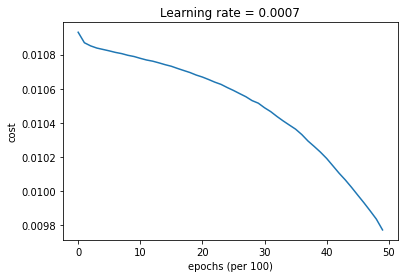

train accuracy: 65.957447%
train accuracy: 50.245339%


In [111]:
# train 3-layer model
layers_dims = [train_set_x.shape[0], 40, 35,25,15,10, 1]
parameters = model(train_set_x, train_set_y, layers_dims, optimizer = "gd")

# Print accuracy
predictions_train = predict(parameters, train_set_x)
predictions_test = predict(parameters, test_set_x)
print ('train accuracy: %f' % float((np.dot(train_set_y, predictions_train.T) + np.dot(1 - train_set_y, 1 - predictions_train.T)) / float(train_set_y.size) * 100) + '%')
print ('train accuracy: %f' % float((np.dot(test_set_y, predictions_test.T) + np.dot(1 - test_set_y, 1 - predictions_test.T)) / float(test_set_y.size) * 100) + '%')


Cost after epoch 0: 0.010931
Cost after epoch 1000: 0.010738
Cost after epoch 2000: 0.010525
Cost after epoch 3000: 0.010090
Cost after epoch 4000: 0.009334


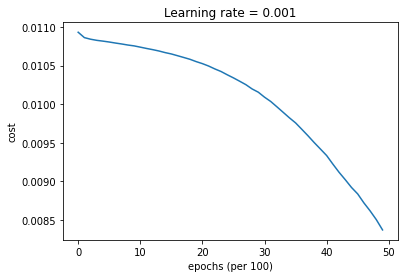

train accuracy: 73.551555%
train accuracy: 50.441609%


In [112]:
# train 3-layer model
layers_dims = [train_set_x.shape[0], 40, 35,25,15,10, 1]
parameters = model(train_set_x, train_set_y, layers_dims, optimizer = "momentum",learning_rate=0.001)

# Print accuracy
predictions_train = predict(parameters, train_set_x)
predictions_test = predict(parameters, test_set_x)
print ('train accuracy: %f' % float((np.dot(train_set_y, predictions_train.T) + np.dot(1 - train_set_y, 1 - predictions_train.T)) / float(train_set_y.size) * 100) + '%')
print ('train accuracy: %f' % float((np.dot(test_set_y, predictions_test.T) + np.dot(1 - test_set_y, 1 - predictions_test.T)) / float(test_set_y.size) * 100) + '%')


Cost after epoch 0: 0.010913


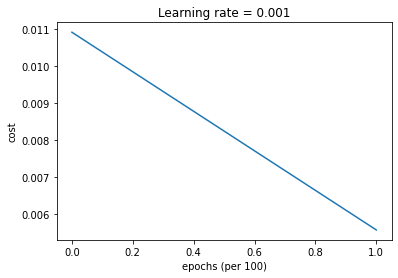

train accuracy: 87.037643%
train accuracy: 51.128557%


In [114]:
# train 3-layer model
layers_dims = [train_set_x.shape[0], 40, 35,25,15,10, 1]
parameters = model(train_set_x, train_set_y, layers_dims, optimizer = "adam",learning_rate=0.001,num_epochs=150)
# Print accuracy
predictions_train = predict(parameters, train_set_x)
predictions_test = predict(parameters, test_set_x)
print ('train accuracy: %f' % float((np.dot(train_set_y, predictions_train.T) + np.dot(1 - train_set_y, 1 - predictions_train.T)) / float(train_set_y.size) * 100) + '%')
print ('train accuracy: %f' % float((np.dot(test_set_y, predictions_test.T) + np.dot(1 - test_set_y, 1 - predictions_test.T)) / float(test_set_y.size) * 100) + '%')
